## Correlation with cicflowmeter

In [1]:
import os
import tqdm
import pickle
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch

In [2]:
def gram_linear(x):
    """Compute Gram (kernel) matrix for a linear kernel.

    Args:
        x: A num_examples x num_features matrix of features.

    Returns:
        A num_examples x num_examples Gram matrix of examples.
    """
    return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
    """Compute Gram (kernel) matrix for an RBF kernel.

    Args:
        x: A num_examples x num_features matrix of features.
        threshold: Fraction of median Euclidean distance to use as RBF kernel
        bandwidth. (This is the heuristic we use in the paper. There are other
        possible ways to set the bandwidth; we didn't try them.)

    Returns:
        A num_examples x num_examples Gram matrix of examples.
    """
    dot_products = x.dot(x.T)
    sq_norms = np.diag(dot_products)
    sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
    sq_median_distance = np.median(sq_distances)
    return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
    """Center a symmetric Gram matrix.

    This is equvialent to centering the (possibly infinite-dimensional) features
    induced by the kernel before computing the Gram matrix.

    Args:
        gram: A num_examples x num_examples symmetric matrix.
        unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
        estimate of HSIC. Note that this estimator may be negative.

    Returns:
        A symmetric matrix with centered columns and rows.
    """
    if not np.allclose(gram, gram.T):
        raise ValueError('Input must be a symmetric matrix.')
    gram = gram.copy()

    if unbiased:
        # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
        # L. (2014). Partial distance correlation with methods for dissimilarities.
        # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
        # stable than the alternative from Song et al. (2007).
        n = gram.shape[0]
        np.fill_diagonal(gram, 0)
        means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
        means -= np.sum(means) / (2 * (n - 1))
        gram -= means[:, None]
        gram -= means[None, :]
        np.fill_diagonal(gram, 0)
    else:
        means = np.mean(gram, 0, dtype=np.float64)
        means -= np.mean(means) / 2
        gram -= means[:, None]
        gram -= means[None, :]

    return gram


def cka(gram_x, gram_y, debiased=False):
    """Compute CKA.

    Args:
        gram_x: A num_examples x num_examples Gram matrix.
        gram_y: A num_examples x num_examples Gram matrix.
        debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
        The value of CKA between X and Y.
    """
    gram_x = center_gram(gram_x, unbiased=debiased)
    gram_y = center_gram(gram_y, unbiased=debiased)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels for CKA.
    scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

    normalization_x = np.linalg.norm(gram_x)
    normalization_y = np.linalg.norm(gram_y)
    return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
    """Compute CKA with a linear kernel, in feature space.

    This is typically faster than computing the Gram matrix when there are fewer
    features than examples.

    Args:
        features_x: A num_examples x num_features matrix of features.
        features_y: A num_examples x num_features matrix of features.
        debiased: Use unbiased estimator of dot product similarity. CKA may still be
        biased. Note that this estimator may be negative.

    Returns:
        The value of CKA between X and Y.
    """
    features_x = features_x - np.mean(features_x, 0, keepdims=True)
    features_y = features_y - np.mean(features_y, 0, keepdims=True)

    dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
    normalization_x = np.linalg.norm(features_x.T.dot(features_x))
    normalization_y = np.linalg.norm(features_y.T.dot(features_y))

    if debiased:
        n = features_x.shape[0]
        # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
        sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
        sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
        squared_norm_x = np.sum(sum_squared_rows_x)
        squared_norm_y = np.sum(sum_squared_rows_y)

        dot_product_similarity = _debiased_dot_product_similarity_helper(
            dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
            squared_norm_x, squared_norm_y, n)
        normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
            squared_norm_x, squared_norm_x, n))
        normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
            squared_norm_y, squared_norm_y, n))

    return dot_product_similarity / (normalization_x * normalization_y)

In [3]:
def calculate_metrics(tensor_path, csv_path, tensor_filename_f=lambda x: x, csv_filename_f=lambda x: x) -> None:
    with open(tensor_path, "rb") as f:
        embeddings, filelist = pickle.load(f)

    filelist = [tensor_filename_f(x) for x in filelist]
    print(f"Filelist length: {len(filelist)}")

    df = pd.read_csv(csv_path)    
    print(f"CSV length: {len(df)}")
    if 'filename' not in df.columns:
        print(df.columns)
        raise ValueError("CSV file must contain a column named 'filename'")
    df['filename'] = df['filename'].apply(csv_filename_f)

    print(filelist[:2])
    print(df['filename'].tolist()[:2])
    
    csv_labels = set(df['filename'].tolist())
    common_files = [fname for fname in filelist if fname in csv_labels]

    df_ordered = df.set_index('filename').loc[common_files].reset_index()
    indices = [i for i, fname in enumerate(filelist) if fname in csv_labels]

    embeddings_filtered = embeddings[indices]
    embeddings_np = embeddings_filtered.cpu().numpy()
    
    print("Filtered embeddings shape:", embeddings_filtered.shape)
    print("Ordered CSV dataframe shape:", df_ordered.shape)

    results = []
    feature_columns = [col for col in df_ordered.columns if col not in {'filename', "Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol", "Timestamp", "Label"}]
    
    for feature in tqdm(feature_columns):
        feature_values = df_ordered[feature].values.reshape(-1, 1)
        cka_val = feature_space_linear_cka(embeddings_np, feature_values)
        results.append({"feature": feature, "cka": cka_val})
    
    results_df = pd.DataFrame(results)    
    return results_df

In [4]:
models = {
    "yatc": lambda x: x.split("/")[-1].removesuffix(".png"),
    "etbert": lambda x: x.split("/")[-1].removesuffix("\n").removesuffix(".pcap"),
    "netfound": lambda x: x.split("/")[-1].removesuffix(".17").removesuffix(".6").removesuffix(".1").removesuffix(".pcap"),
    "netmamba": lambda x: x.split("/")[-1].removesuffix(".png"),    
}

datasets = {"cicids", "cross", "caida", "cicapt", "mawi"}

In [5]:
recalculate = False

if recalculate:
    for dataset in datasets:
        for model in models:
            calculate_metrics(
                f"../data/{model}/{dataset if model != 'netmamba' else f'netmamba_{dataset}'}_emb.pkl",
                f"../data/cicflowmeter/{dataset}.csv",
                models[model],
                lambda x: x.split("/")[-1].removesuffix(".pcap_Flow.csv"),
            ).to_csv(f"../data/cicflowmeter/{model.lower()}_{dataset}_results.csv", index=False)

## Analysis

In [6]:
results = {
    model.lower(): {dataset: None for dataset in datasets}
    for model in models
}

for model in results:
    for dataset in results[model]:
        results[model][dataset] = pd.read_csv(f"../data/cicflowmeter/{model}_{dataset}_results.csv")

In [7]:
dataset_avgs = []
# gather all unique dataset names
all_datasets = {ds for model_data in results.values() for ds in model_data}
for dataset in all_datasets:
    # collect CKA series from each model that has this dataset
    cka_series = [
        df["cka"]
        for model_data in results.values()
        if dataset in model_data
        for df in [model_data[dataset]]
    ]
    combined = pd.concat(cka_series, ignore_index=True)
    dataset_avgs.append({
        "dataset": dataset,
        "dataset_avg_cka": combined.mean()
    })

dataset_avg_df = pd.DataFrame(dataset_avgs)
print("\n(Direct) Average CKA across all models, by dataset:")
print(dataset_avg_df)


(Direct) Average CKA across all models, by dataset:
  dataset  dataset_avg_cka
0    mawi         0.055229
1   cross         0.078214
2  cicids         0.091306
3   caida         0.032214
4  cicapt         0.130613


In [8]:
import pandas as pd

# Collect average CKA per model and dataset
avg_by_dataset = []

for model, model_data in results.items():
    for dataset, df in model_data.items():
        avg_by_dataset.append({
            "model": model,
            "dataset": dataset,
            "avg_cka": df["cka"].mean()
        })

# Convert to DataFrame for easy viewing
avg_df = pd.DataFrame(avg_by_dataset)

# Optionally, pivot so rows are models and columns are datasets
pivot_df = avg_df.pivot(index="model", columns="dataset", values="avg_cka")

print("Average CKA by model and dataset:")
print(pivot_df)


Average CKA by model and dataset:
dataset      caida    cicapt    cicids     cross      mawi
model                                                     
etbert    0.032914  0.013651  0.064177  0.011951  0.026114
netfound  0.052061  0.218550  0.166700  0.156199  0.070300
netmamba  0.029736  0.140748  0.041987  0.046841  0.050762
yatc      0.014143  0.147758  0.091573  0.097865  0.069520


In [9]:
import pandas as pd

for model, model_data in results.items():
    # concat all (now rows are non unique)
    df_list = []
    for dataset, df in model_data.items():
        df_list.append(df)
    df_model = pd.concat(df_list, ignore_index=True)

    # group by feature name
    feature_stats = (
        df_model.groupby("feature")["cka"]
        .agg(["mean", "std"])
        .reset_index()
    )
    
    feature_stats_sorted = feature_stats.sort_values(by="mean", ascending=False)
    top10_features = feature_stats_sorted.head(10)
    overall_avg_corr = df_model["cka"].mean()
    
    print(f"Model: {model}")
    print("Top 10 features (mean correlation and std):")
    print(top10_features)
    print(f"Overall average correlation: {overall_avg_corr}\n")


Model: yatc
Top 10 features (mean correlation and std):
                  feature      mean       std
52       Fwd Seg Size Min  0.422982  0.185394
28     FWD Init Win Bytes  0.339080  0.240681
62      Packet Length Min  0.286129  0.084522
66         SYN Flag Count  0.282184  0.229809
18  Bwd Packet Length Min  0.271972  0.208702
60      Packet Length Max  0.236935  0.126126
27         FIN Flag Count  0.236482  0.199488
5     Average Packet Size  0.230020  0.135069
48  Fwd Packet Length Min  0.225749  0.134640
61     Packet Length Mean  0.217029  0.106008
Overall average correlation: 0.09322722184209391

Model: etbert
Top 10 features (mean correlation and std):
                  feature      mean       std
66         SYN Flag Count  0.122148  0.079755
28     FWD Init Win Bytes  0.080872  0.067531
63      Packet Length Std  0.078144  0.094484
27         FIN Flag Count  0.074110  0.073827
60      Packet Length Max  0.067619  0.097142
19  Bwd Packet Length Std  0.060165  0.075293
49  Fwd 

In [10]:
# latex generation
import pandas as pd

# Start the LaTeX table with header rows.
latex_str = (
    "\\begin{tabular}{lllc}\n"
    "Model & Avg CKA & Top 5 Features & Per-Feature Mean CKA \\\\ \\hline\n"
)

# Loop over each model in the results dictionary.
for model, model_data in results.items():
    # Concatenate all datasets for the current model.
    df_list = [df for df in model_data.values()]
    df_model = pd.concat(df_list, ignore_index=True)

    # Group by feature_name and compute mean and std of correlation.
    feature_stats = (
        df_model.groupby("feature")["cka"]
        .agg(["mean", "std"])
        .reset_index()
    )

    # Sort features by mean correlation in descending order and take top 5.
    feature_stats_sorted = feature_stats.sort_values(by="mean", ascending=False)
    top5 = feature_stats_sorted.head(5)
    
    # Compute overall average correlation for this model.
    overall_avg_corr = df_model["cka"].mean()
    overall_std_corr = df_model["cka"].std()
    
    # Generate table rows for the current model.
    for idx, row in top5.iterrows():
        feature = row["feature"]
        mean_val = row["mean"]
        std_val = row["std"]
        if idx == top5.index[0]:
            # For the first row, add multirow for the model and average correlation.
            latex_str += (
                f"\\multirow{{5}}{{*}}{{{model}}} & \\multirow{{5}}{{*}}{{${overall_avg_corr:.3f}\pm{overall_std_corr:.3f}$}} "
                f"& {feature} & ${mean_val:.3f}\\pm{std_val:.3f}$ \\\\ \n"
            )
        else:
            # For subsequent rows, leave the first two cells empty.
            latex_str += (
                f" &  & {feature} & ${mean_val:.3f}\\pm{std_val:.3f}$ \\\\ \n"
            )
    latex_str += "\\hline\n"

latex_str += "\\end{tabular}"

print(latex_str)


\begin{tabular}{lllc}
Model & Avg CKA & Top 5 Features & Per-Feature Mean CKA \\ \hline
\multirow{5}{*}{yatc} & \multirow{5}{*}{$0.093\pm0.138$} & Fwd Seg Size Min & $0.423\pm0.185$ \\ 
 &  & FWD Init Win Bytes & $0.339\pm0.241$ \\ 
 &  & Packet Length Min & $0.286\pm0.085$ \\ 
 &  & SYN Flag Count & $0.282\pm0.230$ \\ 
 &  & Bwd Packet Length Min & $0.272\pm0.209$ \\ 
\hline
\multirow{5}{*}{etbert} & \multirow{5}{*}{$0.029\pm0.045$} & SYN Flag Count & $0.122\pm0.080$ \\ 
 &  & FWD Init Win Bytes & $0.081\pm0.068$ \\ 
 &  & Packet Length Std & $0.078\pm0.094$ \\ 
 &  & FIN Flag Count & $0.074\pm0.074$ \\ 
 &  & Packet Length Max & $0.068\pm0.097$ \\ 
\hline
\multirow{5}{*}{netfound} & \multirow{5}{*}{$0.143\pm0.194$} & FWD Init Win Bytes & $0.385\pm0.352$ \\ 
 &  & Packet Length Max & $0.372\pm0.302$ \\ 
 &  & Fwd Seg Size Min & $0.359\pm0.338$ \\ 
 &  & Fwd IAT Total & $0.331\pm0.173$ \\ 
 &  & Flow Duration & $0.331\pm0.170$ \\ 
\hline
\multirow{5}{*}{netmamba} & \multirow{5}{*}{$0.0

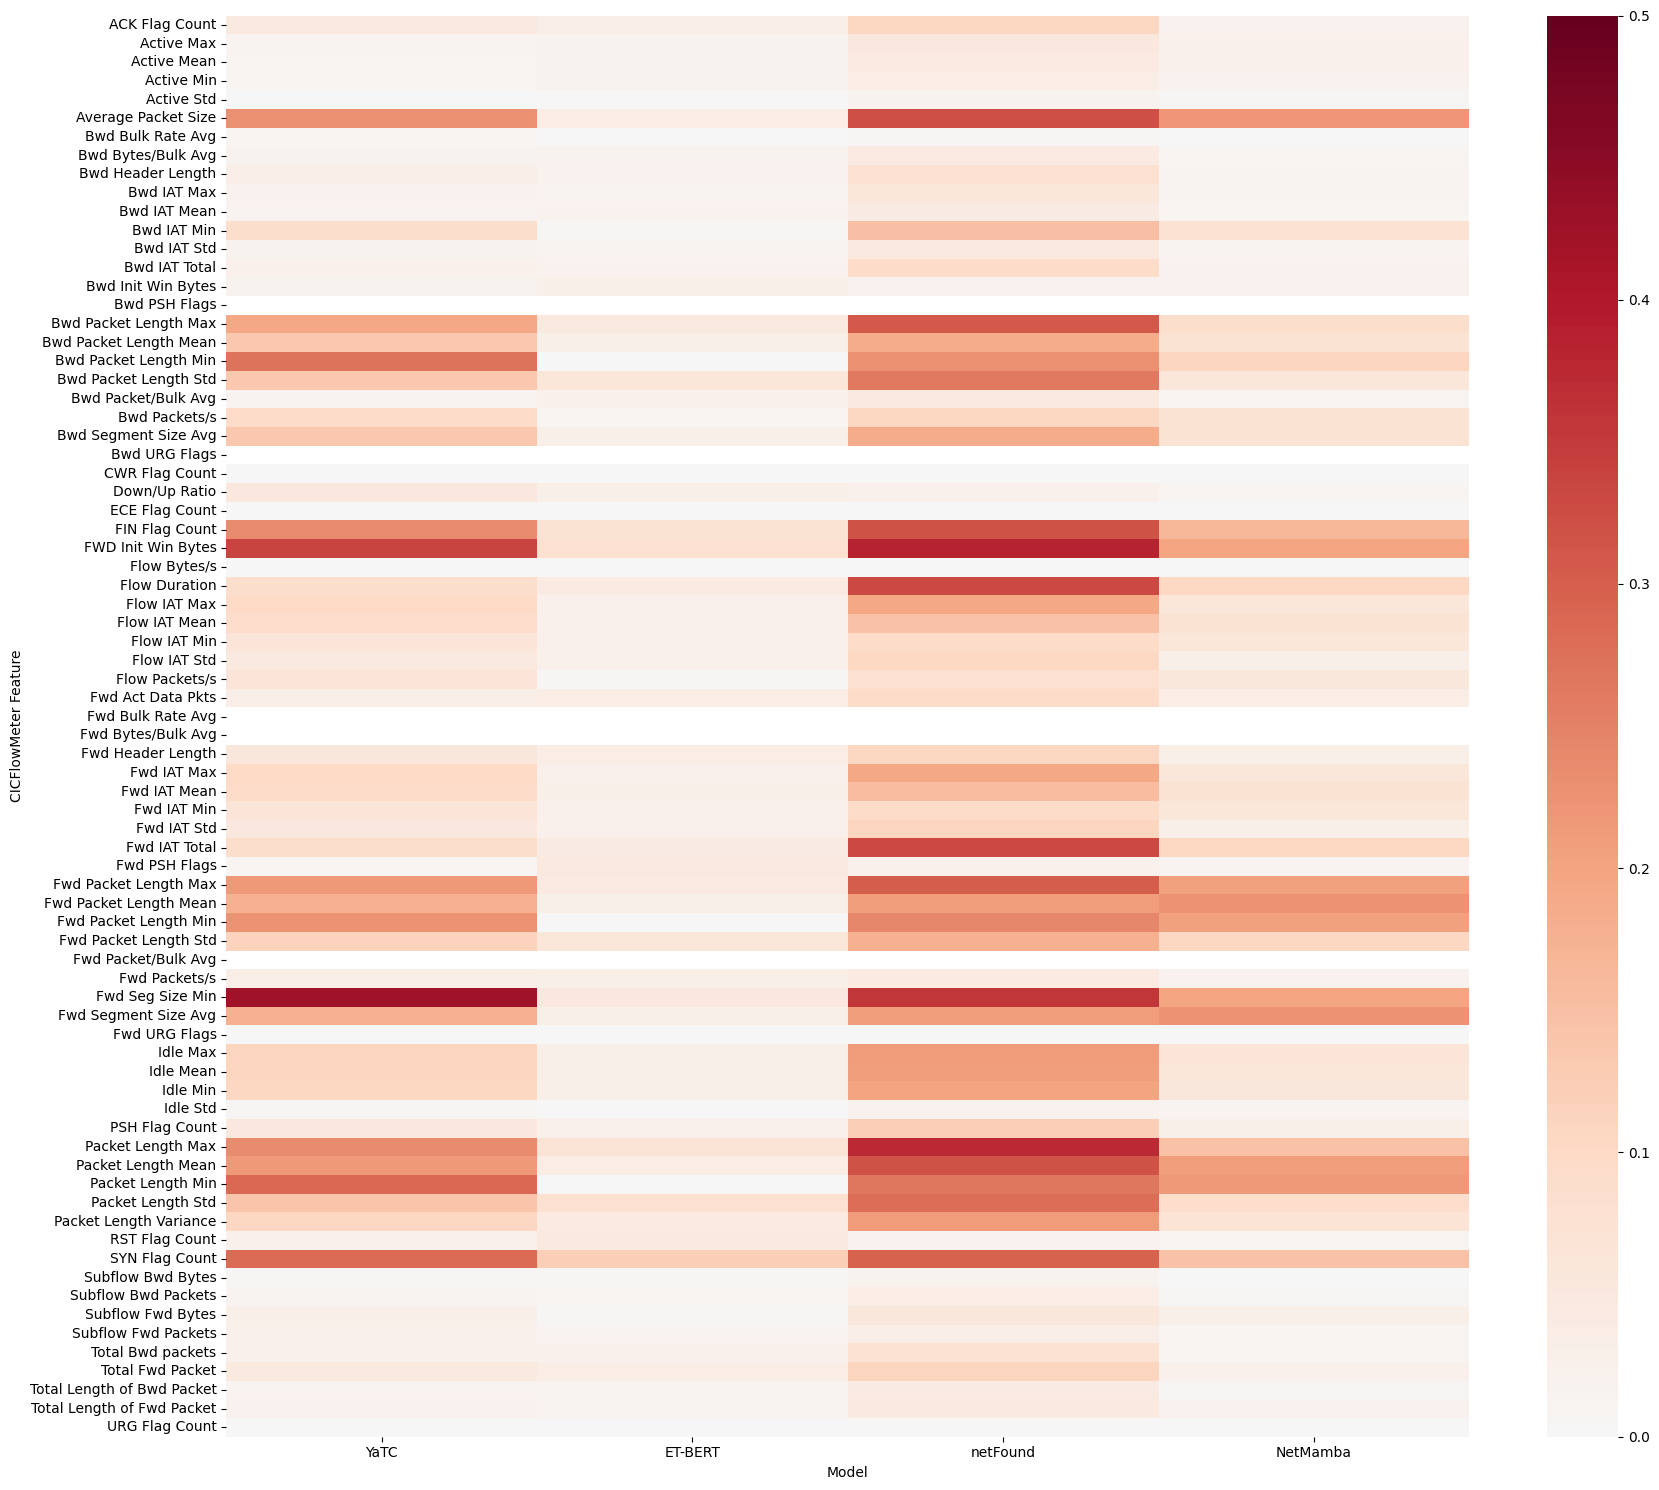

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Aggregate the data across datasets for each model.
#    We'll create a dictionary: { model_name : Series(feature -> avg_correlation), ... }
all_feature_corr = {}

for model_name, dataset_dict in results.items():
    # Concatenate all datasets for this model
    df_list = [df for df in dataset_dict.values()]
    df_model = pd.concat(df_list, ignore_index=True)
    
    # Compute average correlation per feature
    feature_mean_corr = (
        df_model.groupby("feature")["cka"]
        .mean()
    )
    all_feature_corr[model_name] = feature_mean_corr

# 2. Convert this dictionary of Series into a DataFrame
#    with rows = feature names, columns = model names.
df_heatmap = pd.DataFrame(all_feature_corr)

# 3. Sort the features (rows) by feature name to keep them consistent
df_heatmap = df_heatmap.sort_index()

model_names = {
    'yatc': 'YaTC',
    'etbert': 'ET-BERT',
    'netfound': 'netFound',
    'netmamba': 'NetMamba',
}

df_heatmap.columns = [model_names[x] for x in df_heatmap.columns]

# 4. Plot the heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(
    df_heatmap, 
    cmap="RdBu_r",     # or "viridis" / any other palette
    vmin=0, vmax=0.5,   # typical range for correlation
    center=0,          # ensures 0 is the midpoint of the colormap
    annot=False        # set True if you want numeric annotations in each cell
)

# plt.title("Average feature similarity index by model")
plt.xlabel("Model")
plt.ylabel("CICFlowMeter Feature")
plt.tight_layout()
plt.show()


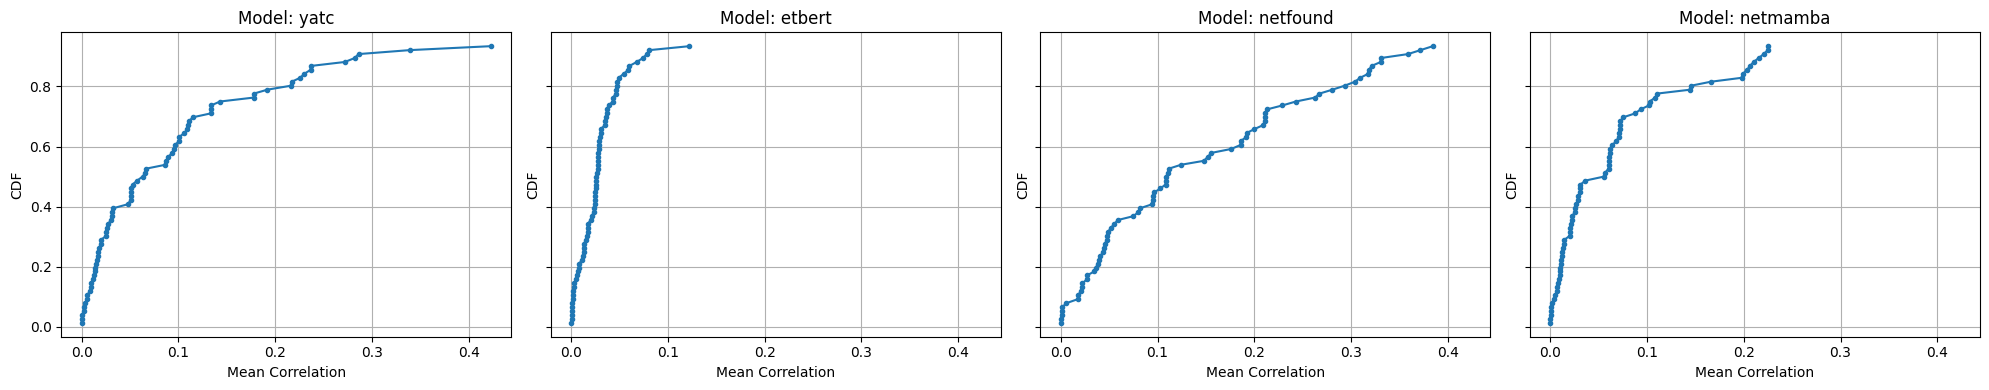

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming `results` is your dictionary where each key is a model name 
# and each value is a dictionary with dataframes for different datasets

models = list(results.keys())
num_models = len(models)

# Create a figure with 1 row and 4 columns (one subplot for each model)
fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 4), sharex=True, sharey=True)

# Loop over each model and its corresponding subplot axis
for ax, model in zip(axes, models):
    # Concatenate data from all datasets of the model
    df_list = []
    for dataset, df in results[model].items():
        df_list.append(df)
    df_model = pd.concat(df_list, ignore_index=True)
    
    # Compute mean cka value for each feature
    feature_stats = df_model.groupby("feature")["cka"].mean().reset_index()
    
    # Sort mean correlations (in ascending order for CDF)
    sorted_means = np.sort(feature_stats["cka"].values)
    
    # Compute empirical CDF: for each sorted value x, its CDF is rank/total number of features
    cdf = np.arange(1, len(sorted_means) + 1) / len(sorted_means)
    
    # Plot the CDF: you can use a line plot or a step plot if you prefer a discrete visualization
    ax.plot(sorted_means, cdf, marker=".", linestyle="-")
    ax.set_title(f"Model: {model}")
    ax.set_xlabel("Mean Correlation")
    ax.set_ylabel("CDF")
    ax.grid(True)

plt.tight_layout()
plt.show()


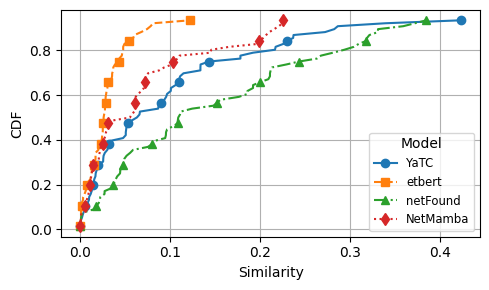

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

# Assuming `results` is your existing dict of model → { dataset: DataFrame, … }
models = list(results.keys())

# Map your internal model keys to camera‑ready names:
model_names = {
    'yatc': 'YaTC',
    'et-bert': 'ET-BERT',
    'netfound': 'netFound',
    'netmamba': 'NetMamba',
    # … add or remove entries as needed
}

# Styles to cycle through
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd', 'x', '+', '*']

fig, ax = plt.subplots(figsize=(5, 3))

for model, ls, mk in zip(models, itertools.cycle(line_styles), itertools.cycle(markers)):
    # Concatenate all datasets for this model
    df_model = pd.concat(results[model].values(), ignore_index=True)
    
    # Compute mean CKA per feature, sort ascending for CDF
    feature_stats = (
        df_model.groupby("feature")["cka"]
                .mean()
                .sort_values()
                .reset_index()
    )
    sorted_means = feature_stats["cka"].values
    
    # Empirical CDF
    cdf = np.arange(1, len(sorted_means) + 1) / len(sorted_means)
    
    # Lookup camera‑ready label (fallback to raw key)
    label = model_names.get(model, model)
    
    ax.plot(
        sorted_means, cdf,
        linestyle=ls,
        marker=mk,
        markevery=max(len(sorted_means)//10, 1),
        label=label
    )

ax.set_xlabel("Similarity")
ax.set_ylabel("CDF")
# ax.set_title("CDF of Similarity per Feature")
ax.grid(True)
ax.legend(title="Model", loc="best", fontsize="small")

plt.tight_layout()
plt.show()


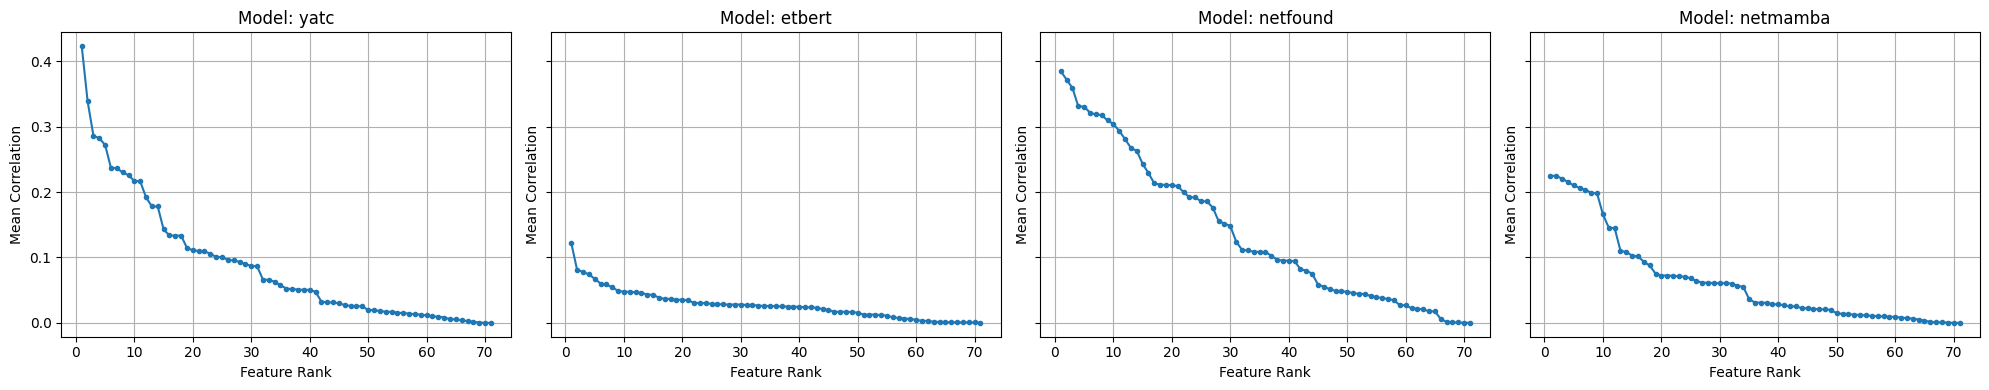

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming `results` is your dictionary where each key is a model name 
# and each value is a dictionary with dataframes for different datasets

models = list(results.keys())
num_models = len(models)

# Create a figure with 1 row and as many columns as there are models
fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 4), sharex=False, sharey=True)

# Loop over each model and its corresponding subplot axis
for ax, model in zip(axes, models):
    # Concatenate all datasets for the current model
    df_list = [df for df in results[model].values()]
    df_model = pd.concat(df_list, ignore_index=True)
    
    # Compute the mean correlation for each feature
    feature_stats = df_model.groupby("feature")["cka"].mean().reset_index()
    
    # Sort the mean correlations in descending order so that rank 1 is the highest correlation
    feature_stats_sorted = feature_stats.sort_values(by="cka", ascending=False)
    
    # Create x-axis as feature ranking (1 to N)
    x = np.arange(1, len(feature_stats_sorted) + 1)
    y = feature_stats_sorted["cka"].values

    # Plot mean correlation (PDF) vs feature rank
    ax.plot(x, y, marker=".", linestyle="-")
    ax.set_title(f"Model: {model}")
    ax.set_xlabel("Feature Rank")
    ax.set_ylabel("Mean Correlation")
    ax.grid(True)

plt.tight_layout()
plt.show()


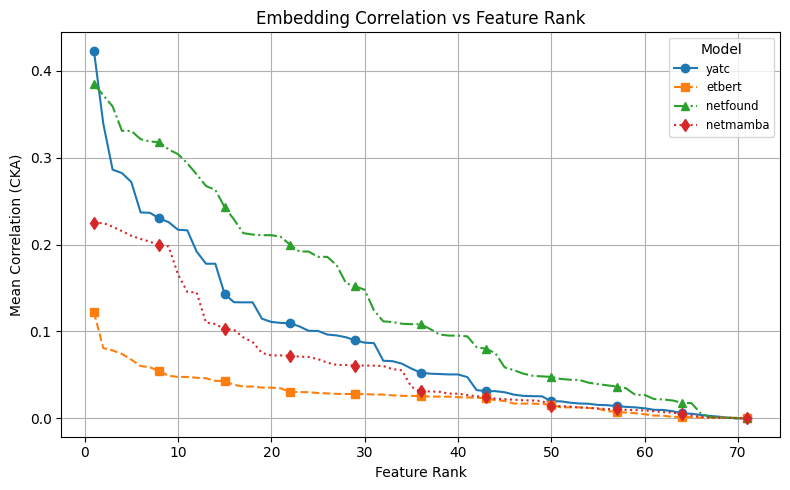

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

models = list(results.keys())

# Define some styles to cycle through
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd', 'x', '+', '*']

# Create one figure/axis
fig, ax = plt.subplots(figsize=(8, 5))

# Loop over each model, assign a style+marker, and plot
for model, ls, mk in zip(models, itertools.cycle(line_styles), itertools.cycle(markers)):
    # Concatenate all datasets for the current model
    df_model = pd.concat(results[model].values(), ignore_index=True)
    
    # Compute mean CKA per feature and sort descending
    feature_stats = (
        df_model.groupby("feature")["cka"]
                .mean()
                .sort_values(ascending=False)
                .reset_index()
    )
    
    x = np.arange(1, len(feature_stats) + 1)
    y = feature_stats["cka"].values
    
    ax.plot(x, y, linestyle=ls, marker=mk, markevery=max(len(x)//10,1),
            label=model)

# Labels, legend, grid
ax.set_xlabel("Feature Rank")
ax.set_ylabel("Mean Correlation (CKA)")
ax.set_title("Embedding Correlation vs Feature Rank")
ax.grid(True)
ax.legend(title="Model", loc="best", fontsize="small")

plt.tight_layout()
plt.show()
